In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xosyasalassa","key":"ee817cad82445813c8cc05e7fb738509"}'}

In [3]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d emmarex/plantdisease

 98% 646M/658M [00:07<00:00, 87.4MB/s]
100% 658M/658M [00:07<00:00, 86.8MB/s]


In [5]:
!unzip "/content/plantdisease.zip" -d "/content/plantdisease"

Streaming output truncated to the last 5000 lines.
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-74761530

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/content/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [11]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/f2acd891-c219-4c76-b2e7-a55c7c9...,14,Tomato_healthy
20635,Tomato_healthy/c6d62e0c-15e0-4e99-8dbd-40e8f71...,14,Tomato_healthy
20636,Tomato_healthy/62fa284f-8fc8-46b7-a74d-71bada5...,14,Tomato_healthy
20637,Tomato_healthy/49291f4a-e689-4a59-8f40-60ee9f1...,14,Tomato_healthy
20638,Tomato_healthy/af409ada-072e-4b27-ab15-5cd0011...,14,Tomato_healthy


In [12]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/7b953f3c-719f-4b0e-b62d-2c651ea...,14,Tomato_healthy
1,Potato___Early_blight/8f6d9148-ae73-42cc-be78-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/2698f5c0-5364-477f-a...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/5ecf00da-161c-4e2f-a525-b9223ad...,14,Tomato_healthy
4,Tomato_Leaf_Mold/08cdd6ec-9dd7-4fc2-a255-11a70...,8,Tomato_Leaf_Mold


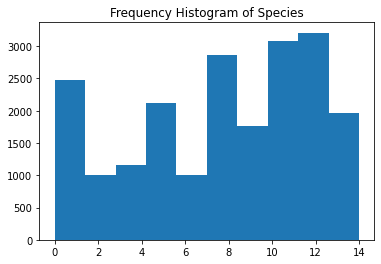

<Figure size 864x864 with 0 Axes>

In [13]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

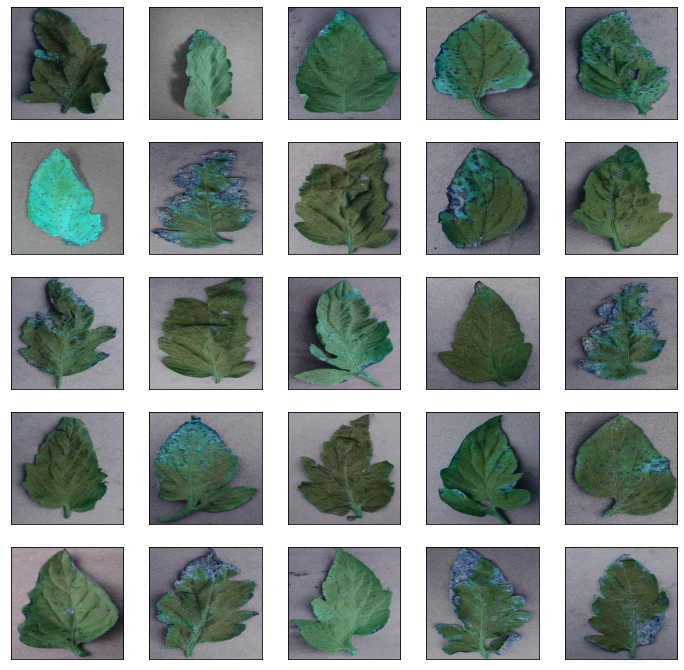

In [14]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [15]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [16]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [00:24, 827.54it/s]


Train Shape: (20639, 64, 64, 3)


In [17]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [18]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

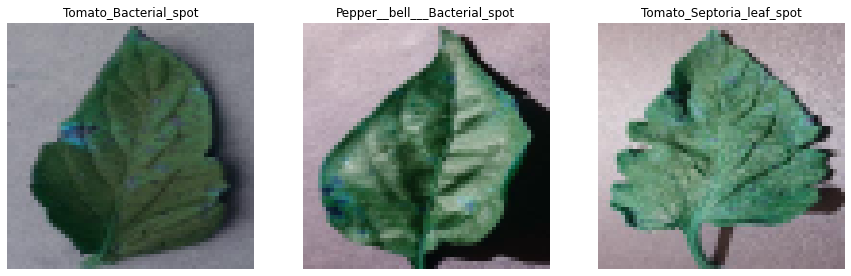

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [29]:
EPOCHS = 200
SIZE=64
N_ch=3

In [30]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [31]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [32]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 [==============================] - 2s 16ms/step - loss: 0.2052 - accuracy: 0.9559
Final Loss: 0.20524361729621887, Final Accuracy: 0.955910861492157


Text(0.5, 144.41374999999996, 'Predicted')

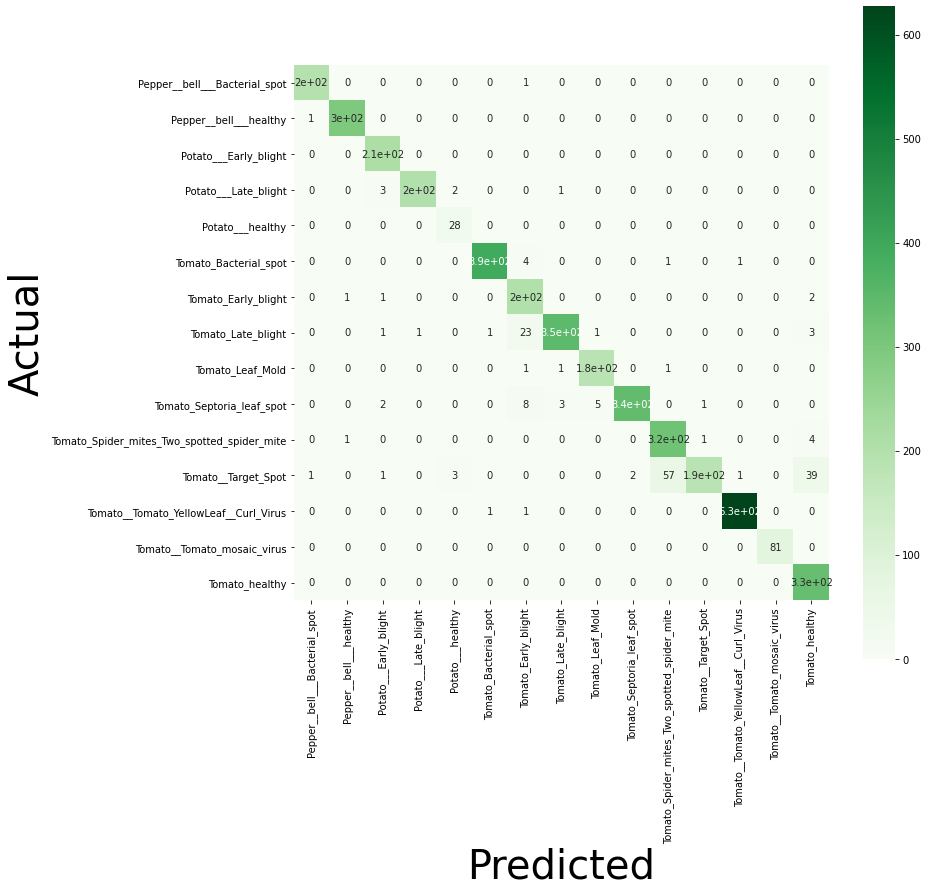

In [33]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

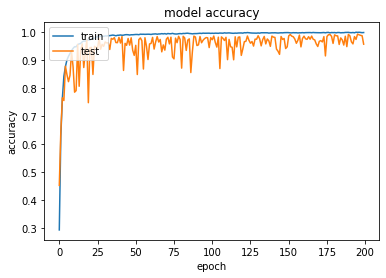

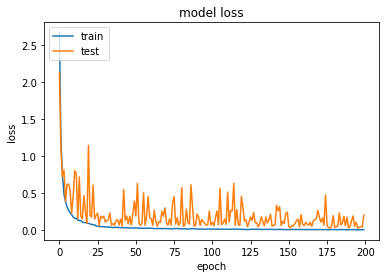

In [34]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Disease Prediction

[4.1188847e-05 6.3587870e-03 4.5297760e-01 1.0069542e-03 3.0735540e-04
 4.6481668e-07 5.3892291e-01 3.8337308e-05 2.7846618e-04 2.8389313e-06
 8.0283564e-07 1.1183402e-05 1.0350096e-06 4.3910160e-05 8.1847847e-06]


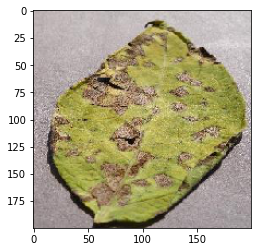

Prediction: Tomato_Early_blight


In [35]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/plantdisease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/plantdisease/PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

# Production Version (Flask Web App) : [Plant Disease Diagnosis](https://github.com/shawon100/Plant-Disease-Diagnosis-Flask)